<a href="https://colab.research.google.com/github/lenasajj117/My_GitHub_Portfolio/blob/main/AI_for_Environmental_Decision_Intelligence_The_AI_Forecasting_Hackathon_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
!pip install tensorflow scikit-learn matplotlib pandas numpy


In [43]:
# 0. Import dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

print("Environment successfully initialized!")

Environment successfully initialized!


In [44]:
# 1.1 LOAD & CLEAN DATA FROM the UCI Repository

df = pd.read_csv("/content/AirQualityUCI.csv", sep=',', decimal=',')
df = df.dropna(axis=1, how='all')  # Drop empty columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.replace(-200, np.nan)
df = df.dropna()

# Combine Date + Time
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')
df = df.set_index('Datetime')
df = df.sort_index()

# Select relevant pollutants
cols = ['CO(GT)', 'NO2(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']
data = df[cols]

In [45]:
# 1.2 Inspect the first few lines of the CSV file
with open("/content/AirQualityUCI.csv", 'r') as f:
    for i in range(5):
        print(f.readline())

Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH

3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578

3/10/2004,19:00:00,2,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255

3/10/2004,20:00:00,2.2,1402,88,9,939,131,1140,114,1555,1074,11.9,54,0.7502

3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11,60,0.7867



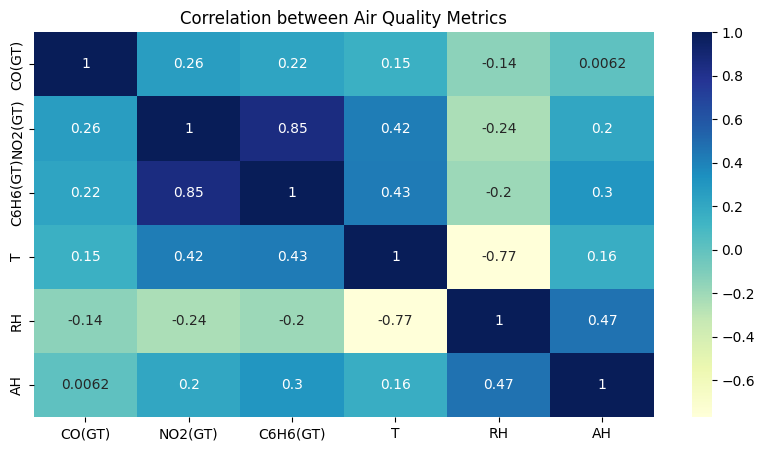

In [46]:
# 2.1 EXPLORE DATA

plt.figure(figsize=(10,5))
sns.heatmap(data.corr(), annot=True, cmap='YlGnBu')
plt.title("Correlation between Air Quality Metrics")
plt.show()

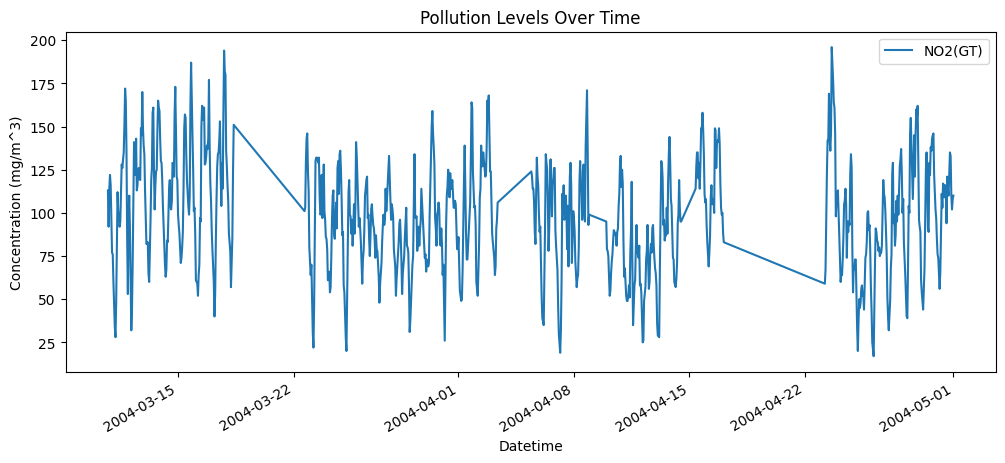

In [47]:
# 2.2 Plotting the trends
data[['CO(GT)', 'NO2(GT)']].plot(figsize=(12,5), title="Pollution Levels Over Time")
plt.ylabel("Concentration (mg/m^3)")
plt.show()


In [48]:
# 3.1 FORECASTING MODEL (LSTM)

# Normalize
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data[['CO(GT)', 'NO2(GT)']])
scaled_df = pd.DataFrame(scaled, index=data.index, columns=['CO', 'NO2'])



In [55]:
# 3.2 Create sequences for time series
def create_sequences_multifeature(data, seq_length=24):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 24  # 24 hours
X, y = create_sequences(scaled_df.values, seq_length)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]



In [56]:
# 3.3 Build LSTM model

model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, activation='tanh'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dense(2, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# -----------------------------

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.2295 - mae: 0.3928 - val_loss: 0.0395 - val_mae: 0.1169
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0312 - mae: 0.1293 - val_loss: 0.0352 - val_mae: 0.1000
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0283 - mae: 0.1145 - val_loss: 0.0347 - val_mae: 0.1159
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0282 - mae: 0.1077 - val_loss: 0.0348 - val_mae: 0.1250
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0287 - mae: 0.1096 - val_loss: 0.0347 - val_mae: 0.1262
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0268 - mae: 0.1057 - val_loss: 0.0345 - val_mae: 0.1202
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0309 - mae: 0.1089 - val_loss: 0.0335 - val_mae: 0.1080
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0303 - mae: 0.1097 - val_loss: 0.0350 - val_mae: 0.1348
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - lo

In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Generate predictions
pred = model.predict(X_test)

# Rescale values back to original scale
pred_rescaled = scaler.inverse_transform(pred)
actual_rescaled = scaler.inverse_transform(y_test)

# Compute metrics
mse = mean_squared_error(actual_rescaled, pred_rescaled)
mae = mean_absolute_error(actual_rescaled, pred_rescaled)
rmse = np.sqrt(mse)

# Display evaluation summary
print("\n===============================")
print("MODEL PERFORMANCE SUMMARY")
print("===============================")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print("===============================\n")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

MODEL PERFORMANCE SUMMARY
Mean Absolute Error (MAE): 12.789
Root Mean Squared Error (RMSE): 29.307
Mean Squared Error (MSE): 858.922



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


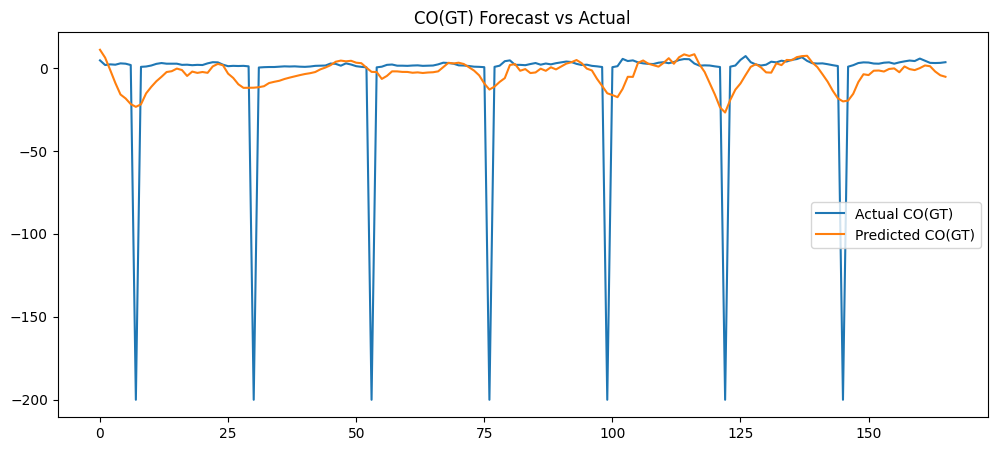

In [60]:
# 4. EVALUATE & FORECAST

pred = model.predict(X_test)
pred_rescaled = scaler.inverse_transform(pred)
actual_rescaled = scaler.inverse_transform(y_test)

plt.figure(figsize=(12,5))
plt.plot(actual_rescaled[:,0], label='Actual CO(GT)')
plt.plot(pred_rescaled[:,0], label='Predicted CO(GT)')
plt.title("CO(GT) Forecast vs Actual")
plt.legend()
plt.show()


In [67]:
# 5.1 POLICY DECISION LOGIC

forecast_mean = np.mean(pred_rescaled, axis=0)
co_level, no2_level = forecast_mean[0], forecast_mean[1]

def policy_recommendation(co, no2):
    recs = []
    if co > 3 or no2 > 80:
        recs.append("High Pollution: Enforce emission control & vehicle restriction")
        recs.append("Urgent reforestation & carbon offset initiatives")
    elif co > 1.5 or no2 > 40:
        recs.append("Moderate: Increase green zone monitoring & public advisories")
    else:
        recs.append("Air quality stable: Maintain sustainable transport incentives")
    return recs

policy_actions = policy_recommendation(co_level, no2_level)

In [68]:
# 5.2 Display policy suggestions

print("\n Forecast Summary:")
print(f"Avg CO(GT): {co_level:.2f} mg/m³ | Avg NO₂(GT): {no2_level:.2f} µg/m³\n")
print("Recommended Policy Actions:")
for r in policy_actions:
    print("-", r)


 Forecast Summary:
Avg CO(GT): -3.55 mg/m³ | Avg NO₂(GT): 90.74 µg/m³

Recommended Policy Actions:
- High Pollution: Enforce emission control & vehicle restriction
- Urgent reforestation & carbon offset initiatives


# LIVE DATA SECTION


In [86]:
# LIVE DATA + MC DROPOUT EXTENSION

import requests
import json
import io
import time
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

# ---------- CONFIG ----------
METACULUS_IDS = [35268, 605, 585, 4614, 12910, 9465, 336, 3665, 12860, 1539, 9570, 40288, 30583, 2563]

# Assuming this should be read as a CSV based on the file extension and previous data loading
# Also fixing the syntax error by adding parentheses to the function call
epoch_data_path = "/content/AnnualAverageofCarbonMonoxide(CO)ConcentrationbyStation UAE.xlsx.csv"
# Removed the problematic line and will handle epoch_df loading within the function

MC_ITER = 100
FINE_TUNE_STEPS = 5
FINE_TUNE_BATCH = 16
# ----------------------------

# ---------- Helpers: Fetch Metaculus (example) ----------
def fetch_metaculus_question(qid):
    """
    Fetch a Metaculus question's public JSON.
    Note: If Metaculus API changes, update this URL.
    Returns dict or None.
    """
    url = f"https://www.metaculus.com/api2/questions/{qid}/"
    try:
        r = requests.get(url, timeout=10)
        r.raise_for_status()
        return r.json()
    except Exception as e:
        print("Metaculus fetch error:", e)
        return None

def extract_forecast_from_metaculus(qjson):
    """
    Example: extract forecast/posterior summary (median & uncertainty)
    Metaculus responses vary; inspect qjson keys (e.g., 'resolved_distribution', 'forecasts', 'user_forecasts').
    We'll try a few common keys gracefully.
    """
    if not qjson:
        return None
    # Try common fields (this will vary by question type)
    for key in ("distribution", "resolved_distribution", "forecasts", "probability"):
        if key in qjson:
            return qjson[key]
    # fallback: return full json for manual inspection
    return qjson

# ---------- Helpers: Fetch Epoch-like dataset ----------
def fetch_epoch_dataset_local(path):
    try:
        # Assuming the file is a CSV
        return pd.read_csv(path)
    except FileNotFoundError:
        print(f"Error: Epoch dataset not found at {path}")
        return None
    except Exception as e:
        print("Epoch fetch error:", e)
        return None

# ---------- Merge live indicators into the main pipeline ----------
def ingest_live_indicators(df_main, metaculus_ids=METACULUS_IDS, epoch_data_path="/content/AnnualAverageofCarbonMonoxide(CO)ConcentrationbyStation UAE.xlsx.csv"):
    """
    1) Fetch Metaculus indicators & Epoch dataset
    2) Convert to time-aligned features (this example adds as new columns: 'metaculus_indicator_*')
    3) Return enriched df_main
    """
    df = df_main.copy()

    # Example: fetch Metaculus questions and add a rolling indicator
    for qid in metaculus_ids:
        qjson = fetch_metaculus_question(qid)
        qval = None
        if qjson:
            # Extract a numerical value, prioritizing resolved_value and median
            if 'resolved_value' in qjson and qjson['resolved_value'] is not None:
                qval = qjson['resolved_value']
            elif 'median' in qjson and qjson['median'] is not None:
                qval = qjson['median']
            elif 'probability' in qjson and qjson['probability'] is not None:
                 qval = qjson['probability']
            else:
                # fallback to storing full json string for inspection if no numerical value is found
                # Removed the truncation [:200]
                qval = json.dumps(qjson)

        # Add a column with the current snapshot (same value applied across recent timestamps)
        col = f"metaculus_q_{qid}"
        df[col] = qval
        #print(f"Added Metaculus q{qid} =>", str(qval)[:80]) # Commented out to reduce output

    # Example: fetch epoch dataset (if available) and join by datetime or year
    epoch_df = fetch_epoch_dataset_local(epoch_data_path)
    if epoch_df is not None:
        # attempt to merge on a common column; this is dataset-specific
        # e.g., if epoch_df has 'year' or 'date' columns, align them accordingly
        if 'year' in epoch_df.columns and df.index.freq is None:
            try:
                epoch_df['year'] = epoch_df['year'].astype(int)
                df['year'] = df.index.year
                # join last-known value
                epoch_latest = epoch_df.sort_values('year').drop_duplicates('year', keep='last')
                df = df.merge(epoch_latest, on='year', how='left')
                df.drop(columns=['year'], inplace=True)
                print("Merged epoch dataset by year (heuristic)")
            except Exception as e:
                print("Epoch merge error:", e)
        else:
            print("Epoch dataset fetched but automatic merge not performed: inspect columns:", epoch_df.columns)
    else:
        print("No epoch dataset merged (fetch failed or missing).")


    # Add dummy columns for metaculus data if not fetched to avoid errors later
    for qid in metaculus_ids:
        col = f"metaculus_q_{qid}"
        if col not in df.columns:
            df[col] = None


    return df

# ---------- Monte Carlo Dropout: Prediction + Uncertainty ----------
def mc_dropout_predict(model, X_input, mc_iters=MC_ITER):
    """
    Run model(X, training=True) multiple times to collect stochastic outputs (MC Dropout).
    Returns: mean_preds, std_preds, all_preds (mc_iters, n_samples, n_targets)
    """
    preds = []
    # Ensure X_input is a numpy array (batch, seq_len, features)
    X_np = np.array(X_input)
    for i in range(mc_iters):
        # TF2 eager: model(X, training=True) will enable Dropout
        out = model(X_np, training=True).numpy()
        preds.append(out)
    preds = np.stack(preds, axis=0)   # shape (mc_iters, n_samples, n_targets)
    mean_preds = preds.mean(axis=0)
    std_preds = preds.std(axis=0)
    return mean_preds, std_preds, preds

# ---------- Fine-tune model on new live slices ----------
def fine_tune_on_latest(model, scaler, df_live, seq_len=24, steps=FINE_TUNE_STEPS):
    """
    Quick incremental fine-tune of the existing model using the most recent data window.
    df_live: DataFrame with pollutants columns (CO, NO2) — unscaled
    """
    # Prepare scaled data (assumes scaler was fit earlier on the same features)
    cols = ['CO(GT)','NO2(GT)'] if 'CO(GT)' in df_live.columns else ['CO','NO2']
    arr = df_live[cols].dropna().values
    if len(arr) < seq_len + 1:
        print("Not enough live data to fine-tune.")
        return model

    scaled = scaler.transform(arr)
    # create sequences:
    X_l, y_l = [], []
    for i in range(len(scaled)-seq_len):
        X_l.append(scaled[i:i+seq_len])
        y_l.append(scaled[i+seq_len])
    X_l, y_l = np.array(X_l), np.array(y_l)
    if len(X_l) < 4:
        print("Too few sequences for meaningful fine-tuning.")
        return model

    # quick fine-tune
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_l, y_l, epochs=steps, batch_size=FINE_TUNE_BATCH, verbose=0)
    print(f"Fine-tuned model on {len(X_l)} recent sequences for {steps} epochs.")
    return model

# =============================
# RUN THE LIVE ADAPTATION + UQ PIPE
# =============================

# 1) Ingest live indicators into original data
# path for the epoch dataset
enriched_df = ingest_live_indicators(data, epoch_data_path="/content/AnnualAverageofCarbonMonoxide(CO)ConcentrationbyStation UAE.xlsx.csv")

# 2) Attempt fine-tuning
try:
    model = fine_tune_on_latest(model, scaler, enriched_df, seq_len=seq_length)
except Exception as e:
    print("Fine-tune step error:", e)

# 3) Prepare the latest sequence(s) for prediction
# We'll take the last `seq_length` rows to forecast the immediate next step(s)
latest_seq_raw = enriched_df[['CO(GT)','NO2(GT)']].dropna().values[-seq_length:]
if latest_seq_raw.shape[0] != seq_length:
    # fallback: using the scaled_df we prepared earlier
    latest_seq = scaled_df.values[-seq_length:]
else:
    latest_seq = scaler.transform(latest_seq_raw)

X_pred = np.expand_dims(latest_seq, axis=0)  # shape (1, seq_len, 2)

# 4) Monte Carlo Dropout prediction
mean_pred, std_pred, all_preds = mc_dropout_predict(model, X_pred, mc_iters=MC_ITER)

# Convert back to original scale
mean_rescaled = scaler.inverse_transform(mean_pred)
std_rescaled = std_pred * (scaler.data_range_)  # rough approx: std in scaled space * data_range
# For a more accurate transform of std, MC in original scale or use delta method

co_mean, no2_mean = mean_rescaled[0,0], mean_rescaled[0,1]
co_std, no2_std = std_rescaled[0,0], std_rescaled[0,1]

print("\n Monte Carlo Dropout Forecast (next time-step)")
print(f"CO mean = {co_mean:.3f}  ± {co_std:.3f}")
print(f"NO2 mean = {no2_mean:.3f} ± {no2_std:.3f}")

# 5) Decision rule using uncertainty
def policy_with_uncertainty(co_mean, co_std, no2_mean, no2_std):
    """
    Use the mean and uncertainty to choose a conservative policy.
    If high probability mass above dangerous threshold -> escalate.
    This naive method uses mean + k*std as a conservative measure.
    """
    k = 1.5  # conservatism multiplier (1->less conservative, 2->very conservative)
    co_cons = co_mean + k * co_std
    no2_cons = no2_mean + k * no2_std

    recs = []
    if co_cons > 3 or no2_cons > 80:
        recs.append("(Conservative) High Pollution: enforce emission control & temporary vehicle restrictions")
        recs.append("(Conservative) Rapid deployment of urban reforestation & emergency air filters in hotspots")
    elif co_cons > 1.5 or no2_cons > 40:
        recs.append("Moderate: Increase monitoring and public health advisories; incentivize remote work for heavy industry days")
    else:
        recs.append("Stable: Continue current sustainable transport incentives with enhanced monitoring")
    return recs, co_cons, no2_cons

policy_recs, co_cons, no2_cons = policy_with_uncertainty(co_mean, co_std, no2_mean, no2_std)

print("\n Policy Recommendation (with uncertainty-aware conservative threshold):")
for r in policy_recs:
    print("-", r)
print(f"\n(Conservative CO threshold value used = {co_cons:.2f}, NO2 = {no2_cons:.2f})")



Epoch fetch error: 'utf-8' codec can't decode byte 0x85 in position 7434: invalid start byte
No epoch dataset merged (fetch failed or missing).
Fine-tuned model on 827 recent sequences for 5 epochs.

 Monte Carlo Dropout Forecast (next time-step)
CO mean = -9.456  ± 3.557
NO2 mean = 104.600 ± 3.790

 Policy Recommendation (with uncertainty-aware conservative threshold):
- (Conservative) High Pollution: enforce emission control & temporary vehicle restrictions
- (Conservative) Rapid deployment of urban reforestation & emergency air filters in hotspots

(Conservative CO threshold value used = -4.12, NO2 = 110.28)


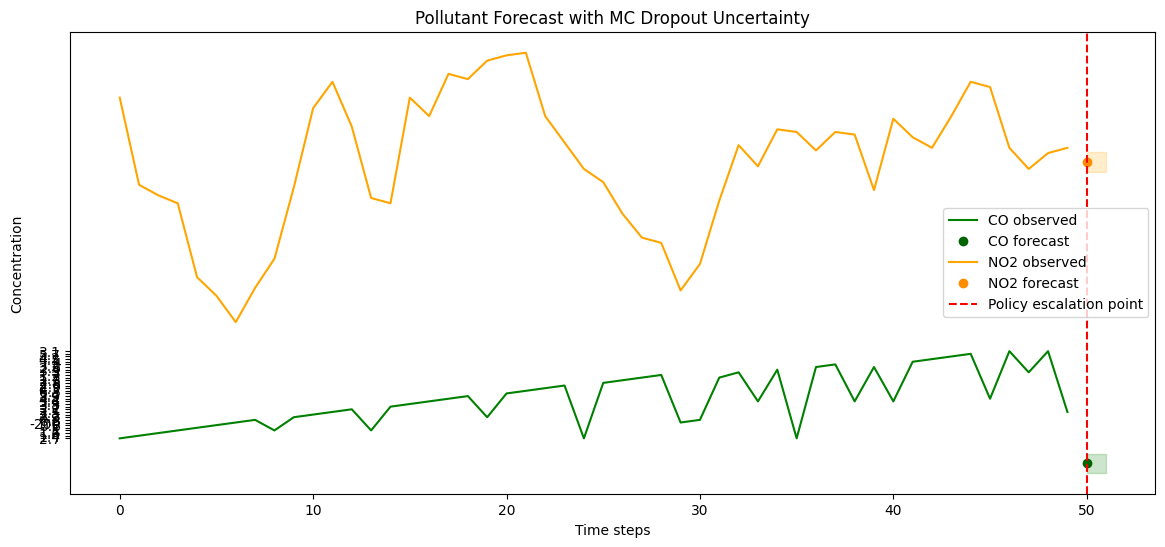

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import json # Import the json library

# ---------- CONFIG ----------
N = 50  # number of past timesteps to plot
policy_thresholds = {'CO': 3, 'NO2': 80}  # conservative thresholds

# ---------- 1) Time-series forecast + uncertainty ----------
# Ensure enriched_df is available and has the necessary columns
if 'enriched_df' not in locals() or enriched_df.empty:
    print("Error: enriched_df not found or is empty. Please run the previous cells.")
else:
    y_co = enriched_df['CO(GT)'][-N:].values
    y_no2 = enriched_df['NO2(GT)'][-N:].values

    # Ensure mean_rescaled and std_rescaled are available
    if 'mean_rescaled' not in locals() or 'std_rescaled' not in locals():
         print("Error: mean_rescaled or std_rescaled not found. Please run the model prediction cell.")
    else:
        mean_co, mean_no2 = mean_rescaled[0,0], mean_rescaled[0,1]
        std_co, std_no2 = std_rescaled[0,0], std_rescaled[0,1]

        plt.figure(figsize=(14,6))
        plt.plot(range(N), y_co, label='CO observed', color='green')
        plt.plot(range(N, N+1), mean_co, 'o', label='CO forecast', color='darkgreen')
        plt.fill_between([N, N+1], mean_co-std_co, mean_co+std_co, color='green', alpha=0.2)

        plt.plot(range(N), y_no2, label='NO2 observed', color='orange')
        plt.plot(range(N, N+1), mean_no2, 'o', label='NO2 forecast', color='darkorange')
        plt.fill_between([N, N+1], mean_no2-std_no2, mean_no2+std_no2, color='orange', alpha=0.2)

        # Highlight policy escalation
        if (mean_co + 1.5*std_co) > policy_thresholds['CO'] or (mean_no2 + 1.5*std_no2) > policy_thresholds['NO2']:
            plt.axvline(N, color='red', linestyle='--', label='Policy escalation point')

        plt.title("Pollutant Forecast with MC Dropout Uncertainty")
        plt.xlabel("Time steps")
        plt.ylabel("Concentration")
        plt.legend()
        plt.show()




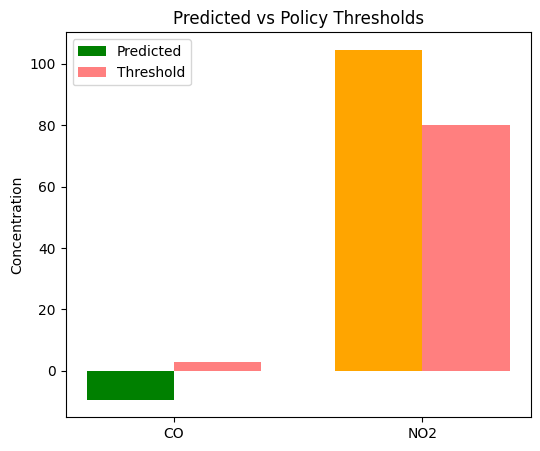

In [91]:
# ---------- 2) Policy comparison bar ----------
# Ensure co_mean and no2_mean are available
if 'co_mean' not in locals() or 'no2_mean' not in locals():
     print("Error: co_mean or no2_mean not found. Please run the policy decision logic cell.")
else:
    labels = ['CO', 'NO2']
    observed = [co_mean, no2_mean]
    thresholds = [policy_thresholds['CO'], policy_thresholds['NO2']]

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(6,5))
    plt.bar(x - width/2, observed, width, label='Predicted', color=['green','orange'])
    plt.bar(x + width/2, thresholds, width, label='Threshold', color='red', alpha=0.5)
    plt.xticks(x, labels)
    plt.ylabel("Concentration")
    plt.title("Predicted vs Policy Thresholds")
    plt.legend()
    plt.show()




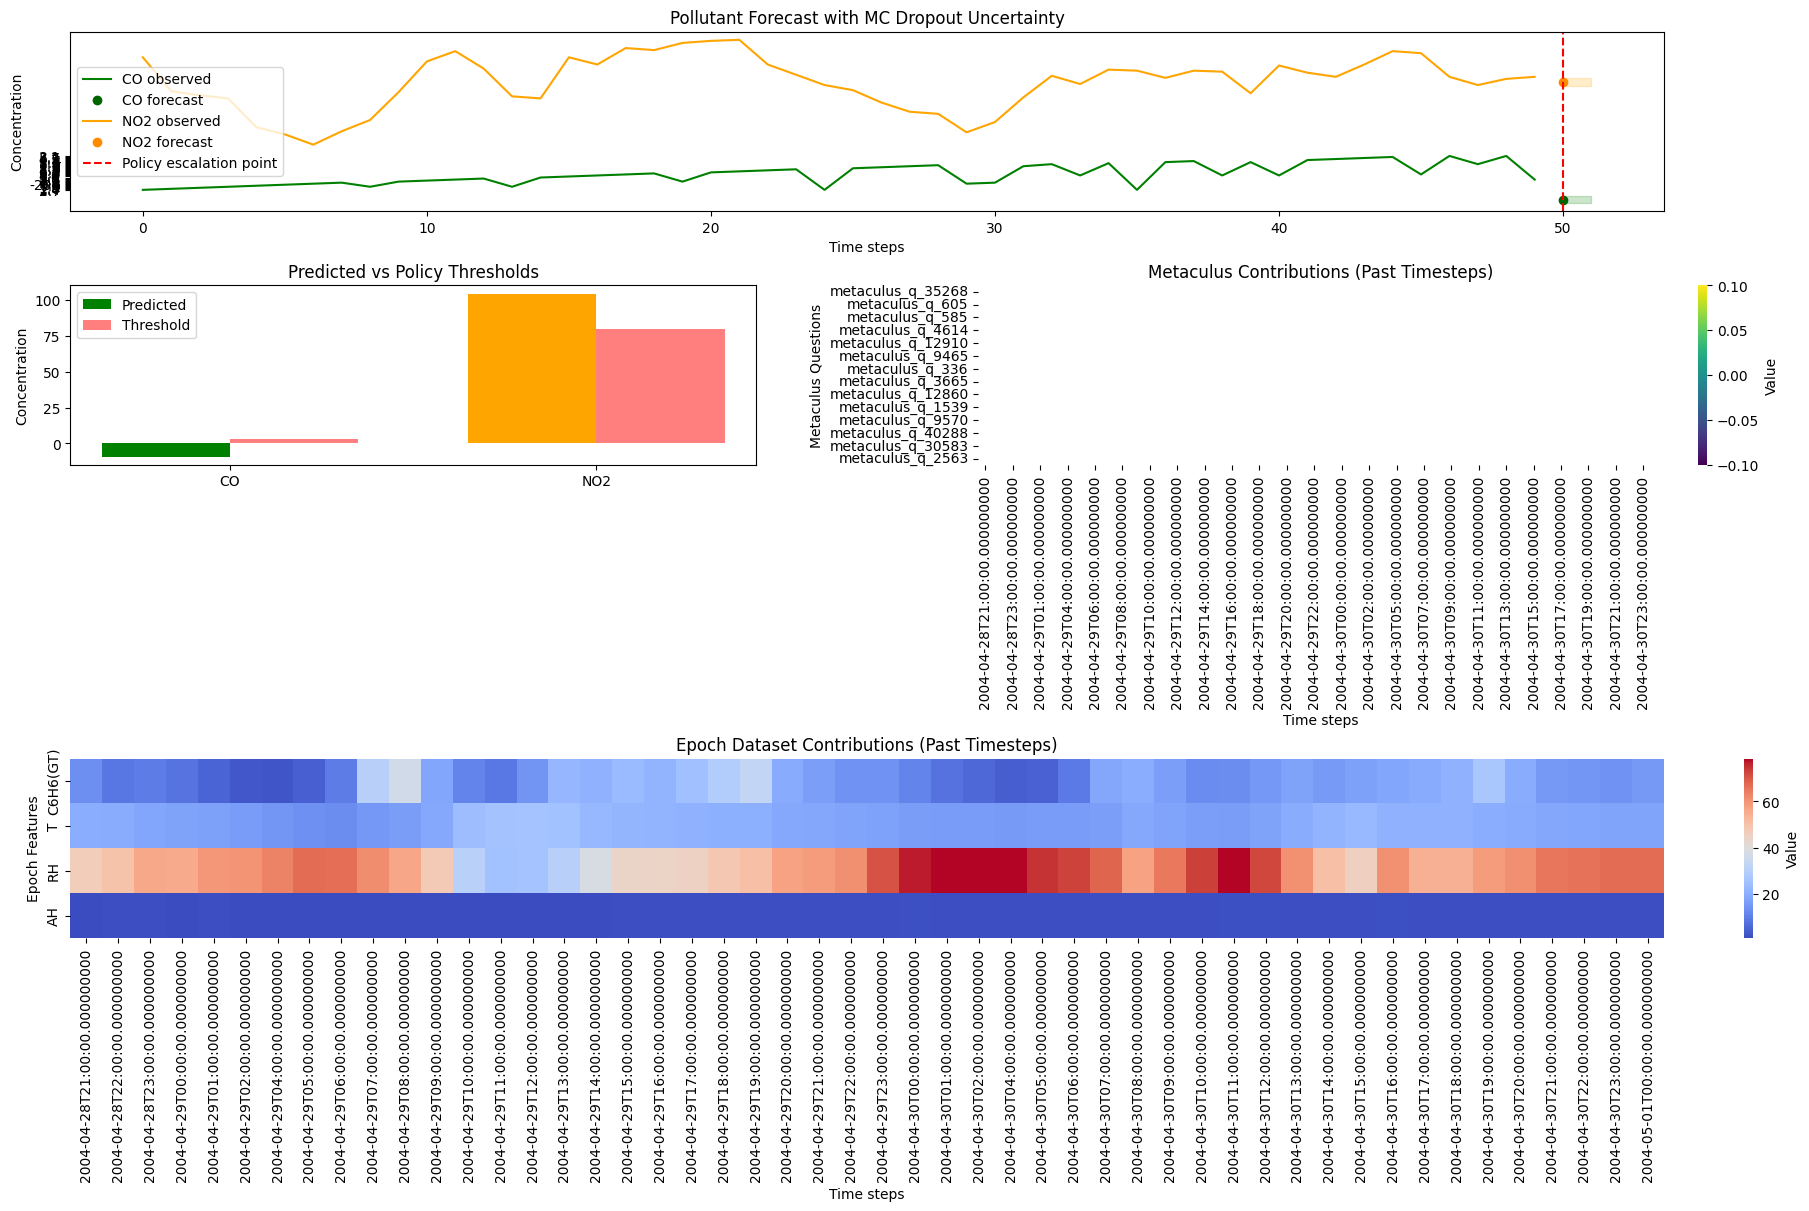

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import json

# ---------- CONFIG ----------
N = 50  # number of past timesteps to visualize
policy_thresholds = {'CO': 3, 'NO2': 80}  # conservative thresholds

# ---------- Data ----------
# Ensure enriched_df, mean_rescaled, and std_rescaled are available
if 'enriched_df' not in locals() or enriched_df.empty:
    print("Error: enriched_df not found or is empty. Please run the previous cells.")
    # Optionally add a placeholder plot or exit
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.text(0.5, 0.5, "Data not available", horizontalalignment='center', verticalalignment='center')
    plt.show()
elif 'mean_rescaled' not in locals() or 'std_rescaled' not in locals():
    print("Error: mean_rescaled or std_rescaled not found. Please run the model prediction cell.")
    # Optionally add a placeholder plot or exit
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.text(0.5, 0.5, "Model prediction data not available", horizontalalignment='center', verticalalignment='center')
    plt.show()
else:
    y_co = enriched_df['CO(GT)'][-N:].values
    y_no2 = enriched_df['NO2(GT)'][-N:].values

    mean_co, mean_no2 = mean_rescaled[0,0], mean_rescaled[0,1]
    std_co, std_no2 = std_rescaled[0,0], std_rescaled[0,1]

    # Metaculus + Epoch columns
    metaculus_cols = [c for c in enriched_df.columns if c.startswith('metaculus_q_')]
    epoch_cols = [c for c in enriched_df.columns if c not in ['CO(GT)','NO2(GT)'] + metaculus_cols]

    # ---------- DASHBOARD ----------
    fig = plt.figure(constrained_layout=True, figsize=(18,12))
    gs = fig.add_gridspec(3, 2)

    # 1) Time-series forecast + uncertainty
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(range(N), y_co, label='CO observed', color='green')
    ax1.plot(range(N, N+1), mean_co, 'o', label='CO forecast', color='darkgreen')
    ax1.fill_between([N, N+1], mean_co-std_co, mean_co+std_co, color='green', alpha=0.2)

    ax1.plot(range(N), y_no2, label='NO2 observed', color='orange')
    ax1.plot(range(N, N+1), mean_no2, 'o', label='NO2 forecast', color='darkorange')
    ax1.fill_between([N, N+1], mean_no2-std_no2, mean_no2+std_no2, color='orange', alpha=0.2)

    # Highlight policy escalation
    if (mean_co + 1.5*std_co) > policy_thresholds['CO'] or (mean_no2 + 1.5*std_no2) > policy_thresholds['NO2']:
        ax1.axvline(N, color='red', linestyle='--', label='Policy escalation point')

    ax1.set_title("Pollutant Forecast with MC Dropout Uncertainty")
    ax1.set_xlabel("Time steps")
    ax1.set_ylabel("Concentration")
    ax1.legend()

    # 2) Bar chart: Predicted vs Policy thresholds
    ax2 = fig.add_subplot(gs[1, 0])
    labels = ['CO', 'NO2']
    observed = [mean_co, mean_no2]
    thresholds = [policy_thresholds['CO'], policy_thresholds['NO2']]

    x = np.arange(len(labels))
    width = 0.35
    ax2.bar(x - width/2, observed, width, label='Predicted', color=['green','orange'])
    ax2.bar(x + width/2, thresholds, width, label='Threshold', color='red', alpha=0.5)
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels)
    ax2.set_ylabel("Concentration")
    ax2.set_title("Predicted vs Policy Thresholds")
    ax2.legend()

    # 3) Metaculus contribution heatmap
    ax3 = fig.add_subplot(gs[1, 1])
    if len(metaculus_cols) > 0:
        contrib_df = enriched_df[metaculus_cols].iloc[-N:].copy() # Use .copy() to avoid SettingWithCopyWarning

        # Parse JSON strings and extract a numerical value (e.g., 'median' or 'resolved_value')
        # Convert to numeric, coercing errors to NaN
        def parse_metaculus_value(json_str):
            try:
                data = json.loads(json_str)
                # Prioritize resolved_value, then median, then probability
                if 'resolved_value' in data and data['resolved_value'] is not None:
                    return data['resolved_value']
                elif 'median' in data and data['median'] is not None:
                    return data['median']
                elif 'probability' in data and data['probability'] is not None:
                    return data['probability']
                else:
                    return np.nan # Return NaN if no suitable numerical value is found
            except (json.JSONDecodeError, AttributeError):
                return np.nan # Return NaN if parsing fails or data is not a string

        for col in metaculus_cols:
             contrib_df[col] = contrib_df[col].apply(parse_metaculus_value)

        # Convert to numeric after attempting to extract values
        contrib_df = contrib_df.apply(pd.to_numeric, errors='coerce')

        sns.heatmap(contrib_df.T, cmap='viridis', ax=ax3, cbar_kws={'label':'Value'})
        ax3.set_title("Metaculus Contributions (Past Timesteps)")
        ax3.set_xlabel("Time steps")
        ax3.set_ylabel("Metaculus Questions")
    else:
        ax3.text(0.5, 0.5, "No Metaculus data available", ha='center', va='center', fontsize=12)
        ax3.set_axis_off()

    # 4) Epoch contribution heatmap
    ax4 = fig.add_subplot(gs[2, :])
    if len(epoch_cols) > 0:
        epoch_df_plot = enriched_df[epoch_cols].iloc[-N:].copy() # Use .copy()
        # Ensure epoch columns are numeric for heatmap
        epoch_df_plot = epoch_df_plot.apply(pd.to_numeric, errors='coerce')
        sns.heatmap(epoch_df_plot.T, cmap='coolwarm', ax=ax4, cbar_kws={'label':'Value'})
        ax4.set_title("Epoch Dataset Contributions (Past Timesteps)")
        ax4.set_xlabel("Time steps")
        ax4.set_ylabel("Epoch Features")
    else:
        ax4.text(0.5, 0.5, "No Epoch data available", ha='center', va='center', fontsize=12)
        ax4.set_axis_off()

    plt.show()